# MINE Mutual Information Estimation in Zero-Dispersion Optical Channel 

This code is provided as supplementary material of the lecture Machine Learning and Optimization in Communications (MLOC).<br>

This code illustrates
* Using the MINE mutual information estimator to compute the achievable information rate (AIR) of the channel

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np

import matplotlib.pyplot as plt
from ipywidgets import interactive
import ipywidgets as widgets

%matplotlib inline 

device = 'cuda' if torch.cuda.is_available() else 'cpu'
print("We are using the following device for learning:",device)

We are using the following device for learning: cuda


In [8]:
def simulate_channel(x, EsN0):      
    EsN0_lin = 10**(EsN0/10.0)
    sigma = np.sqrt(1.0/2.0/EsN0_lin)
    
    y = x + sigma * np.random.randn(len(x))
    
    return x,y

In [20]:
class Variational_Function(nn.Module):
    def __init__(self, hidden_neurons_1, hidden_neurons_2):
        super(Variational_Function, self).__init__()
        
        # Linear function, 2 input neurons (channel input and channel output)
        self.fc1 = nn.Linear(2, hidden_neurons_1) 

        # Non-linearity
        self.activation_function = nn.ELU()
    
        # Soft-sign
        self.softsign = nn.Softsign()
    
        # Linear function (hidden layer)
        self.fc2 = nn.Linear(hidden_neurons_1, hidden_neurons_2)  
        
        # Output layer generating a scalar
        self.fc3 = nn.Linear(hidden_neurons_2, 1)
                

    def forward(self, x):
        # Linear function, first layer
        out = self.fc1(x)

        # Non-linearity, first layer
        out = self.activation_function(out)
        
        # Linear function, second layer
        out = self.fc2(out)
        
        # Non-linearity, second layer
        out = self.activation_function(out)
        
        # Linear function, output layer
        out = 20.0 * torch.tanh(self.fc3(out))
        
        return out

In [22]:
EsN0 = 10.0

MI_reference = 0.5*np.log2(1 + 2 * 10.0**(EsN0/10.0))

hidden_neurons_1 = 50
hidden_neurons_2 = 30


# Generate variational function
model = Variational_Function(hidden_neurons_1, hidden_neurons_2)
model.to(device)

# Adam Optimizer
optimizer = optim.Adam(model.parameters())  

num_epochs = 100
batches_per_epoch = 500

# increase batch size while learning from 100 up to 10000
batch_size_per_epoch = np.linspace(100, 10000, num=num_epochs, dtype=int)

for epoch in range(num_epochs):
    for step in range(batches_per_epoch):
        
        
        t,r = simulate_channel(np.random.randn(batch_size_per_epoch[epoch]), EsN0)
        _,rtilde = simulate_channel(np.random.randn(batch_size_per_epoch[epoch]), EsN0)
        
        model.train()
                
        # generate input to first call of the variational function
        input_1 = np.vstack( (t, r) ).transpose()
        torch_in1 = torch.from_numpy(input_1).float().to(device)
        
        # generate input to second call of the variational function
        input_2 = np.vstack( (t, rtilde) ).transpose()
        torch_in2 = torch.from_numpy(input_2).float().to(device)
        
        # apply the variational function
        out_1 = model(torch_in1)
        out_2 = model(torch_in2)
        
        
        # loss function. Attenation, put a minus sign as we want to maximize
        loss = -torch.mean(out_1) + torch.log(torch.mean(torch.exp(out_2)))
                
        # compute gradients
        loss.backward() 
        
        # carry out one optimization step with Adam
        optimizer.step()
        
        # reset gradients to zero
        optimizer.zero_grad()
        
    model.eval()
    t,r = simulate_channel(np.random.randn(10000), EsN0)
    _,rtilde = simulate_channel(np.random.randn(10000), EsN0)
        
        
    # generate input to first call of the variational function
    input_1 = np.vstack( (t,r) ).transpose()
    torch_in1 = torch.from_numpy(input_1).float().to(device)
        
    # generate input to second call of the variational function
    input_2 = np.vstack( (t,rtilde) ).transpose()
    torch_in2 = torch.from_numpy(input_2).float().to(device)
        
    # apply the variational function
    out_1 = model(torch_in1)
    out_2 = model(torch_in2)
        
    # loss function. Attenation, put a minus sign as we want to maximize
    MI_eval = torch.mean(out_1) - torch.log2(torch.mean(torch.pow(2.0, out_2)))
    print('Epoch %d: current MI estimate is %1.3f bit/channel use (reference: %1.3f bit/channel use)' % (epoch, MI_eval.cpu().detach().numpy(), MI_reference) )




Epoch 0: current MI estimate is 2.048 bit/channel use (reference: 2.196 bit/channel use)
Epoch 1: current MI estimate is 2.092 bit/channel use (reference: 2.196 bit/channel use)
Epoch 2: current MI estimate is 2.083 bit/channel use (reference: 2.196 bit/channel use)
Epoch 3: current MI estimate is 2.048 bit/channel use (reference: 2.196 bit/channel use)
Epoch 4: current MI estimate is 2.171 bit/channel use (reference: 2.196 bit/channel use)
Epoch 5: current MI estimate is 2.121 bit/channel use (reference: 2.196 bit/channel use)
Epoch 6: current MI estimate is 2.163 bit/channel use (reference: 2.196 bit/channel use)
Epoch 7: current MI estimate is 2.105 bit/channel use (reference: 2.196 bit/channel use)
Epoch 8: current MI estimate is 2.061 bit/channel use (reference: 2.196 bit/channel use)
Epoch 9: current MI estimate is 2.142 bit/channel use (reference: 2.196 bit/channel use)
Epoch 10: current MI estimate is 2.157 bit/channel use (reference: 2.196 bit/channel use)
Epoch 11: current MI

Epoch 92: current MI estimate is 2.083 bit/channel use (reference: 2.196 bit/channel use)
Epoch 93: current MI estimate is 2.117 bit/channel use (reference: 2.196 bit/channel use)
Epoch 94: current MI estimate is 2.122 bit/channel use (reference: 2.196 bit/channel use)
Epoch 95: current MI estimate is 2.125 bit/channel use (reference: 2.196 bit/channel use)
Epoch 96: current MI estimate is 2.141 bit/channel use (reference: 2.196 bit/channel use)
Epoch 97: current MI estimate is 2.110 bit/channel use (reference: 2.196 bit/channel use)
Epoch 98: current MI estimate is 2.136 bit/channel use (reference: 2.196 bit/channel use)
Epoch 99: current MI estimate is 2.139 bit/channel use (reference: 2.196 bit/channel use)


Now we train a GMM for each constellation point individually. We will use this one to compute the mutual information (and hence the performance of a transmission scheme) later

In [50]:
def MINE_getMI_AWGN(EsN0):
    # Generate variational function
    model = Variational_Function(hidden_neurons_1, hidden_neurons_2)
    model.to(device)

    # Adam Optimizer
    optimizer = optim.Adam(model.parameters())  

    num_epochs = 20
    batches_per_epoch = 1000

    # increase batch size while learning from 100 up to 10000
    batch_size_per_epoch = np.linspace(100, 10000, num=num_epochs, dtype=int)

    for epoch in range(num_epochs):
        for step in range(batches_per_epoch):
            t,r = simulate_channel(np.random.randn(batch_size_per_epoch[epoch]), EsN0)
            _,rtilde = simulate_channel(np.random.randn(batch_size_per_epoch[epoch]), EsN0)

            model.train()

            # generate input to first call of the variational function
            input_1 = np.vstack( (t, r) ).transpose()
            torch_in1 = torch.from_numpy(input_1).float().to(device)

            # generate input to second call of the variational function
            input_2 = np.vstack( (t, rtilde) ).transpose()
            torch_in2 = torch.from_numpy(input_2).float().to(device)

            # apply the variational function
            out_1 = model(torch_in1)
            out_2 = model(torch_in2)


            # loss function. Attenation, put a minus sign as we want to maximize
            loss = -torch.mean(out_1) + torch.log(torch.mean(torch.exp(out_2)))

            # compute gradients
            loss.backward() 

            # carry out one optimization step with Adam
            optimizer.step()

            # reset gradients to zero
            optimizer.zero_grad()
        
    model.eval()
    t,r = simulate_channel(np.random.randn(100000), EsN0)
    _,rtilde = simulate_channel(np.random.randn(100000), EsN0)


    # generate input to first call of the variational function
    input_1 = np.vstack( (t,r) ).transpose()
    torch_in1 = torch.from_numpy(input_1).float().to(device)

    # generate input to second call of the variational function
    input_2 = np.vstack( (t,rtilde) ).transpose()
    torch_in2 = torch.from_numpy(input_2).float().to(device)

    # apply the variational function
    out_1 = model(torch_in1)
    out_2 = model(torch_in2)

    # Obtain mutual information
    MI_eval = torch.mean(out_1) - torch.log2(torch.mean(torch.pow(2.0, out_2)))
    
    return MI_eval.cpu().detach().numpy()

In [34]:
from ipywidgets import IntProgress
from IPython.display import display

num_elements = 10
esno_range = np.linspace(-10,10, num_elements)


f = IntProgress(min=0, max=num_elements) # instantiate the bar
display(f) # display the bar

MI_ref = np.zeros(num_elements)
MI_MINE = np.zeros(num_elements)

for i,esno in enumerate(esno_range):
    MI_ref[i] = 0.5*np.log2(1 + 2 * 10.0**(esno/10.0))
    MI_MINE[i] = MINE_getMI_AWGN(esno)
    
    # increase progress bar
    f.value += 1

IntProgress(value=0, max=10)

[0.1315172  0.20767388 0.31915829 0.47367141 0.67483192 0.92060402
 1.20420232 1.51672272 1.84964727 2.19615871]


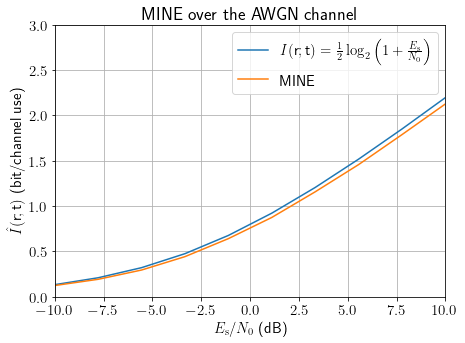

In [49]:
# plotting options 
import matplotlib
font = {'size'   : 15}
plt.rc('font', **font)
plt.rc('text', usetex=matplotlib.checkdep_usetex(True))

plt.figure(figsize=(7,5))
plt.plot(esno_range, MI_ref)
plt.plot(esno_range, MI_MINE)
plt.xlim((-10,10))
plt.ylim((0,3))
plt.grid(True)
plt.legend([r'${I}(\mathsf{r};\mathsf{t}) = \frac{1}{2} \log_2\left(1+\frac{E_{\mathrm{s}}}{N_0}\right)$','MINE'])
plt.title('MINE over the AWGN channel');
plt.xlabel('$E_{\mathrm{s}}/N_0$ (dB)')
plt.ylabel('$\\hat{I}(\mathsf{r};\mathsf{t})$ (bit/channel use)')

plt.savefig('MINE_AWGN.pdf',bbox_inches='tight')